## Results of point pollution surface oil spill scenarios at Active Pass
Tug towing a fuel barge misjudges the tides in Active Pass and barge gets pushed on the rocks puncturing one of its fuel tanks, spilling 500 m<sup>-3</sup> of marine diesel. Scenario is built on ROC report 869, 2019.

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot
from mpl_toolkits.axes_grid1 import make_axes_locatable
from parcels import plotTrajectoriesFile

In [2]:
# Reading in Atlantis map
shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df_original = gpd.read_file(shapefile_name)
data_df_original = data_df_original.sort_values(by=['BOX_ID'])
data_df = data_df_original.set_index('BOX_ID')
box_depth = data_df['BOTZ']
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]
land_df = data_df.loc[land_boxes]
jdf_df = data_df.loc[data_df.Region=='Juan de Fuca']
hs_df = data_df.loc[data_df.Region=='Howe Sound']
strait_df = data_df.loc[data_df.Region=='Strait of Georgia']
ps_df = data_df.loc[data_df.Region=='Puget Sound']

### Define scenario and control files

In [3]:
# Oil injection file 
oil_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/notebooks/contaminant-dispersal/results/ForcingFiles/')
oil_paths = sorted([p for p in oil_root.glob('SSAM_Scenario_4a*_10000_fromzarr.nc')])
oil_files = [xr.open_dataset(oil_scen,decode_cf=True) for oil_scen in oil_paths]

In [3]:
# Read in salish sea atlantis output files.
scenario_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1')

control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Tests/v6719_50y_VBITBUCKET-ddmove0-2-ZGppreyWS-1-PL-fishing/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True)
time = np.ma.filled(control.variables['t'])

In [4]:
scenario_paths = sorted([p for p in scenario_root.glob('Scenario_4a*/outputSalishSea.nc')])
for path in scenario_paths:
    print(path.parent.stem, groups.conditions[str(path.parent.stem).split(sep = '_')[2]])

Scenario_4a_2019-07-10 low Fraser flow, summer neap tide
Scenario_4a_2020-07-12 high Fraser flow, summer neap tide


Scenarios 4a_2019-07-16 and 4a_2020-07-20 (both spring tide) failed close to the time of oil injection with the following error:
- deposit: Bottom water column layer filled with sediment, box 1, t = 905299200

In [5]:
scenario_datasets = [xr.open_dataset(scen,decode_cf=True) for scen in scenario_paths]

In [6]:
# start and end time of data display, after burn-in
start = 100
end = time.size-1

### Mapping spill extent

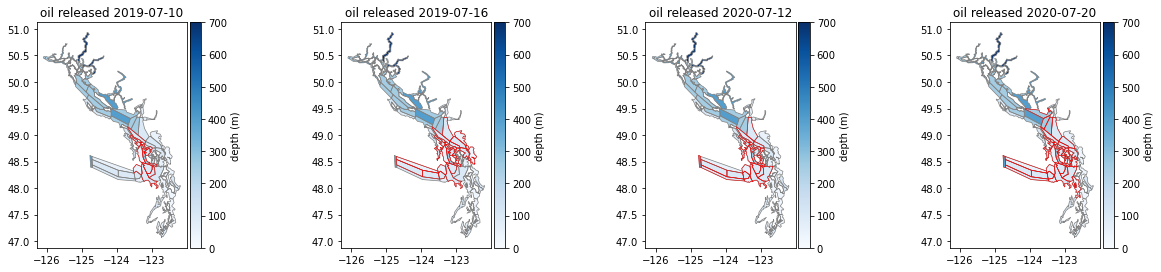

In [8]:
fig = plt.figure(figsize=(20, 10), facecolor='white') #figsize=(9, 12)
gs = plt.GridSpec(1, len(oil_files), wspace=0.5, hspace=0.2, height_ratios=[1],)

position = 0

for file, oil_path in zip(oil_files, oil_paths):
    label = str(oil_path).split(sep = '_')[3]
    oil_tb = file.variables['oil']
    oil_b = oil_tb.mean(axis=0)

    # Add scenario data to Atlantis spatial data
    data_df['oil'] = oil_b
    data_df.loc[land_boxes, 'oil'] = 0
    oil_df = data_df.loc[data_df['oil'] > 0]

    ax = fig.add_subplot(gs[0, position])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=-0.5) 
    ax = data_df.plot(column = 'BOTZ', ax=ax, cax=cax,cmap=cm.Blues,
    legend=True, legend_kwds={'label': 'depth (m)'
    },)
    ax.set_title('oil released '+label, fontsize = 12)
    data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
    land_df.plot(ax=ax, color='white')
    oil_df.boundary.plot(ax=ax, color='red',linewidths=0.5)
    position = position+1

### Oil injection

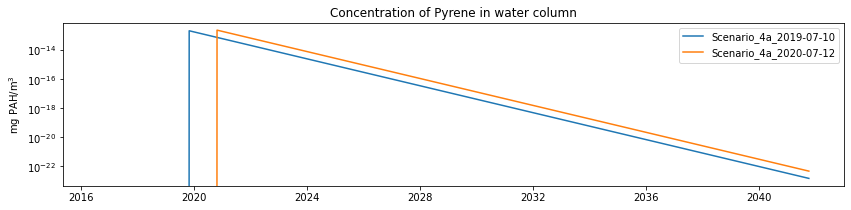

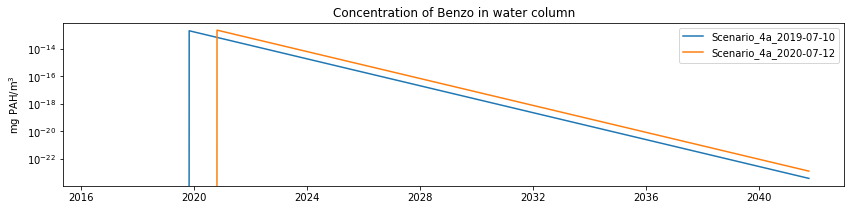

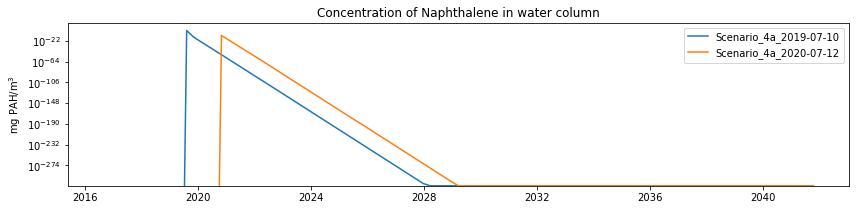

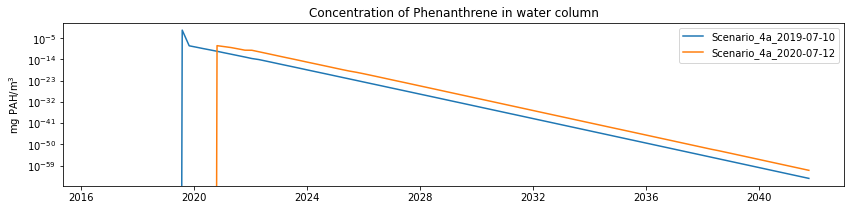

In [9]:
for pah in groups.pahs:
    splot.plot_pah(pah, scenario_datasets, scenario_paths, start, end)

## Results
### Time-separate box plots

In [7]:
print('closest time points to 2019 spill: ' + str(time[116]))
print('5 years post spill: ' + str((time[132])))
print('10 years post spill: ' + str(time[152]))
print('20 years post spill: ' + str(time[193]))

closest time points to 2019 spill: 2020-07-31T14:00:00.000000000
5 years post spill: 2024-07-10T14:00:00.000000000
10 years post spill: 2029-06-14T14:00:00.000000000
20 years post spill: 2039-07-22T14:00:00.000000000


In [8]:
print('closest time points to 2020 spill: ' + str(time[120]))
print('5 years post spill: ' + str((time[136])))
print('10 years post spill: ' + str(time[156]))
print('20 years post spill: ' + str(time[197]))

closest time points to 2020 spill: 2021-07-26T14:00:00.000000000
5 years post spill: 2025-07-05T14:00:00.000000000
10 years post spill: 2030-06-09T14:00:00.000000000
20 years post spill: 2040-07-16T14:00:00.000000000


In [9]:
days2019summer = [116, 132, 152, 193]
days2020summer = [120, 136, 156, 197]

In [10]:
def progressive_boxplot_pelagic(bio_group, location=groups.salish_sea, x_lim=None):
    all_results = []
    data_labels = ['spill year', '5 years later', '10 years later', '20 years later']

    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        year = str(nm[2]).split(sep='-')[0]
        scenario_name = groups.conditions[nm[2]]  # Readable scenario name

        if year == '2019':
            end_days = days2019summer
        elif year == '2020':
            end_days = days2020summer

        for species in bio_group:
            results = []
            for day in end_days:
                p_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][start:day, location, 0:6], np.nan)
                p_control = np.ma.filled(control.variables[bio_group[species] + '_N'][start:day, location, 0:6], np.nan)
                
                p_oiled = p_oiled.sum(axis=(1, 2)).mean()
                p_control = p_control.sum(axis=(1, 2)).mean()
                
                ratio = (p_oiled / p_control - 1) * 100
                results.append(ratio)
            results.append(groups.sensitivity[species])

            for label, value in zip(data_labels, results):
                all_results.append({
                    'bio_group': bio_group[species],
                    'sensitivity': groups.sensitivity[species],
                    'time_label': label,
                    'scenario': scenario_name,
                    'percent_change': value
                })

    # Step 2: Convert to DataFrame
    df = pd.DataFrame(all_results)
    #df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/4a-active-pass-"+str(bio_group[species])+".csv")
    #print(df)
    
    # Step 3: Set up the plot
    time_labels = df['time_label'].unique()
    bio_groups = df['bio_group'].unique()
    scenarios = df['scenario'].unique()
    colors = plt.cm.tab10.colors

    n_rows = 1
    n_cols = len(time_labels)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 6), sharey=True)

    if n_cols == 1:
        axes = [axes]  # Make iterable if only 1 subplot

    bar_width = 0.8 / len(scenarios)  # space per group divided by number of scenarios
    y_pos = np.arange(len(bio_groups))

    # Step 4: Plot each time label subplot
    for i, time in enumerate(time_labels):
        ax = axes[i]
        for j, scenario in enumerate(scenarios):
            df_plot = df[(df['time_label'] == time) & (df['scenario'] == scenario)]
            df_plot = df_plot.set_index('bio_group').reindex(bio_groups)  # Ensure consistent order
            offset = (j - len(scenarios)/2) * bar_width + bar_width/2

            ax.barh(y_pos + offset, df_plot['percent_change'], height=bar_width, label=scenario, color=colors[j % len(colors)])
        ax.barh(y_pos + offset, df_plot['sensitivity'], height=bar_width, label=scenario, color='grey')
        
        ax.set_title(time)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(bio_groups, fontsize=12) 
        ax.set_xlim(x_lim)
        ax.set_xlabel("Percent Change")
        #ax.axvline(0, color='gray', linestyle='--')

    # Step 5: Final layout
    fig.legend(np.append(scenarios,'model sensitivity'), loc='upper center', ncol=len(scenarios)+1, fontsize=12) 
    #plt.tight_layout(rect=[0, 0, 1, 0.95])
    #axes[0].set_ylabel(bio_groups)
    plt.show()

In [15]:
def progressive_boxplot_benthic(bio_group, location=groups.salish_sea, x_lim=None):
    all_results = []
    data_labels = ['spill year', '5 years later', '10 years later', '20 years later']

    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        year = str(nm[2]).split(sep='-')[0]
        scenario_name = groups.conditions[nm[2]]  # Readable scenario name

        if year == '2019':
            end_days = days2019summer
        elif year == '2020':
            end_days = days2020summer

        for species in bio_group:
            results = []
            for day in end_days:
                p_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][start:day, location], np.nan)
                p_control = np.ma.filled(control.variables[bio_group[species] + '_N'][start:day, location], np.nan)
                
                p_oiled = p_oiled.sum(axis=(1)).mean()
                p_control = p_control.sum(axis=(1)).mean()
                
                ratio = (p_oiled / p_control - 1) * 100
                results.append(ratio)
            results.append(groups.sensitivity[species])

            for label, value in zip(data_labels, results):
                all_results.append({
                    'bio_group': bio_group[species],
                    'sensitivity': groups.sensitivity[species],
                    'time_label': label,
                    'scenario': scenario_name,
                    'percent_change': value
                })

    # Step 2: Convert to DataFrame
    df = pd.DataFrame(all_results)
    #df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/4a-active-pass-benthos.csv")
    #print(df)
    
    # Step 3: Set up the plot
    time_labels = df['time_label'].unique()
    bio_groups = df['bio_group'].unique()
    scenarios = df['scenario'].unique()
    colors = plt.cm.tab10.colors

    n_rows = 1
    n_cols = len(time_labels)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 6), sharey=True)

    if n_cols == 1:
        axes = [axes]  # Make iterable if only 1 subplot

    bar_width = 0.8 / len(scenarios)  # space per group divided by number of scenarios
    y_pos = np.arange(len(bio_groups))

    # Step 4: Plot each time label subplot
    for i, time in enumerate(time_labels):
        ax = axes[i]
        for j, scenario in enumerate(scenarios):
            df_plot = df[(df['time_label'] == time) & (df['scenario'] == scenario)]
            df_plot = df_plot.set_index('bio_group').reindex(bio_groups)  # Ensure consistent order
            offset = (j - len(scenarios)/2) * bar_width + bar_width/2

            ax.barh(y_pos + offset, df_plot['percent_change'], height=bar_width, label=scenario, color=colors[j % len(colors)])
        ax.barh(y_pos + offset, df_plot['sensitivity'], height=bar_width, label=scenario, color='grey')
        
        ax.set_title(time)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(bio_groups, fontsize=12) 
        ax.set_xlim(x_lim)
        ax.set_xlabel("Percent Change")
        #ax.axvline(0, color='gray', linestyle='--')

    # Step 5: Final layout
    fig.legend(np.append(scenarios,'model sensitivity'), loc='upper center', ncol=len(scenarios)+1, fontsize=12) 
    #plt.tight_layout(rect=[0, 0, 1, 0.95])
    #axes[0].set_ylabel(bio_groups)
    plt.show()

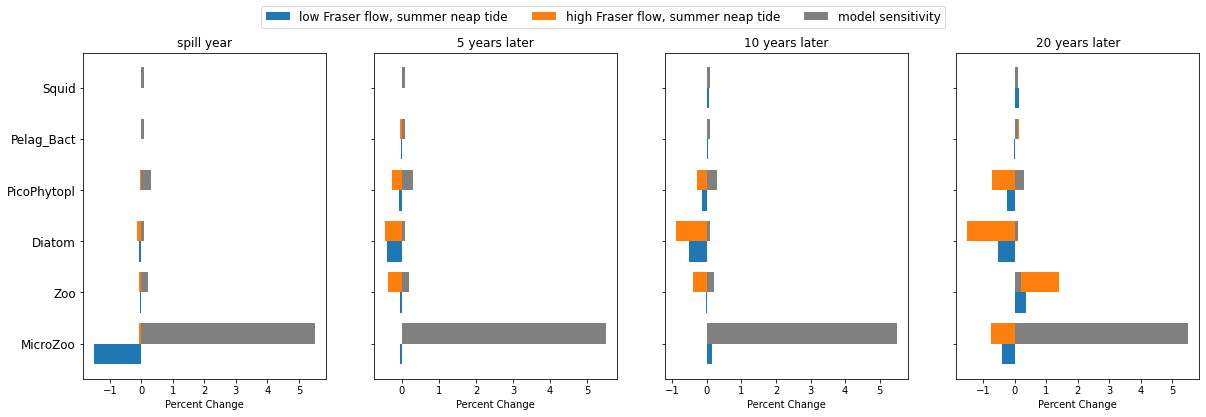

In [12]:
progressive_boxplot_pelagic(groups.planktonic)

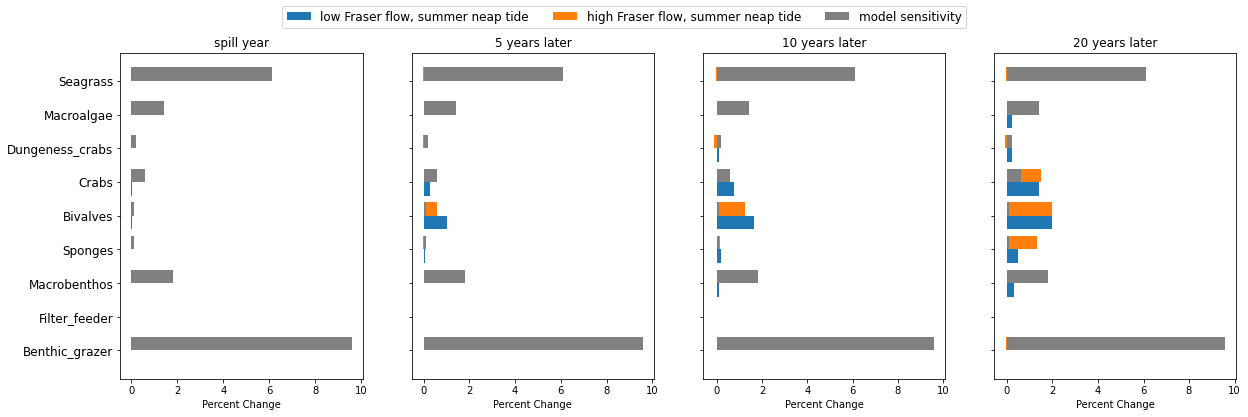

In [16]:
progressive_boxplot_benthic(groups.benthos)

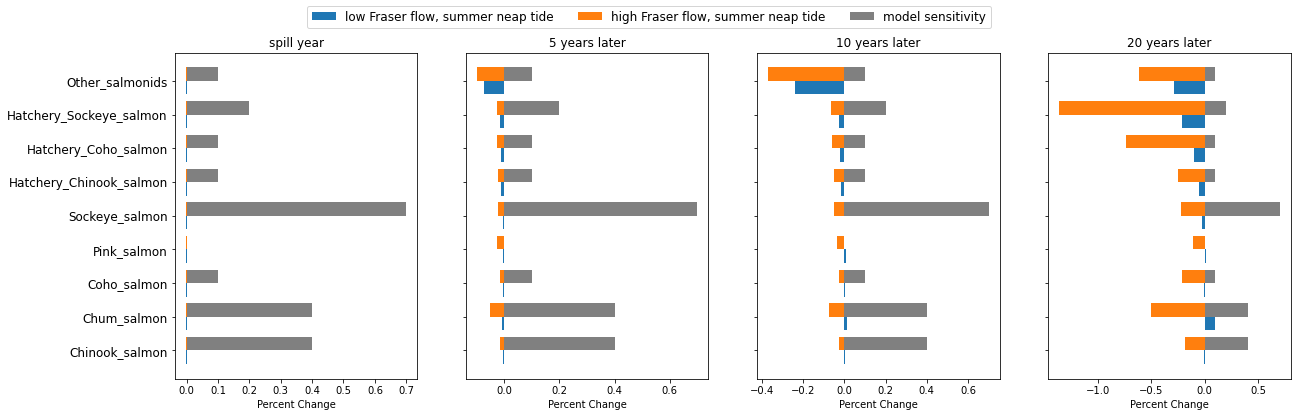

In [17]:
progressive_boxplot_pelagic(groups.salmon)

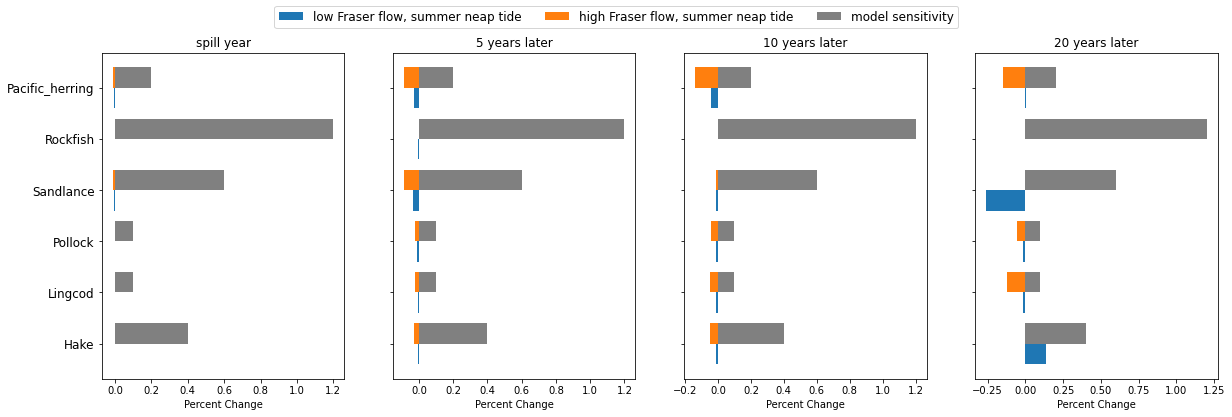

In [18]:
progressive_boxplot_pelagic(groups.named_fish)

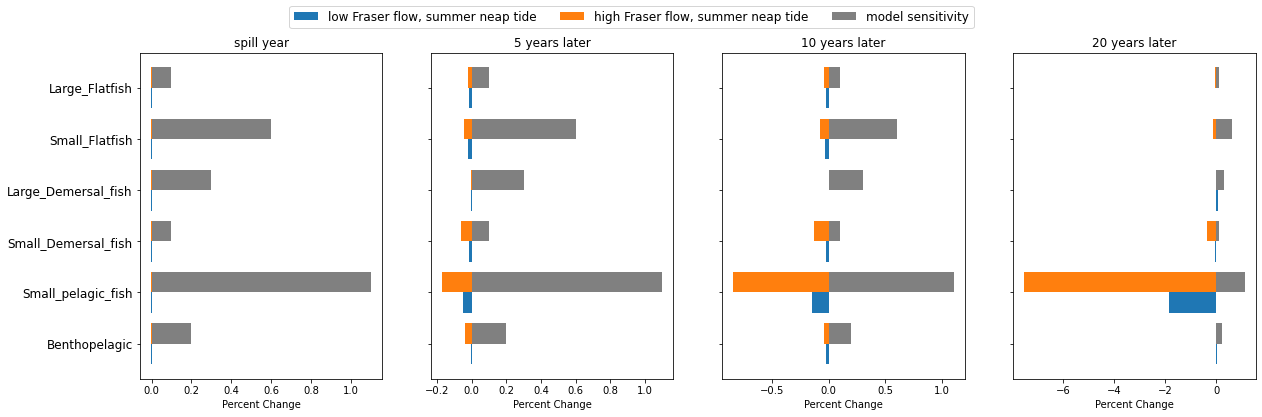

In [19]:
progressive_boxplot_pelagic(groups.other_fish)

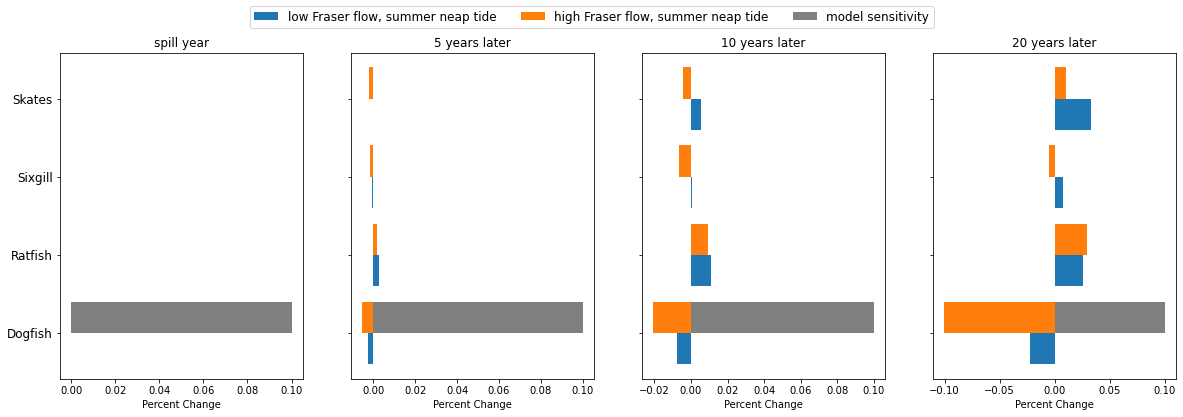

In [20]:
progressive_boxplot_pelagic(groups.sharks)

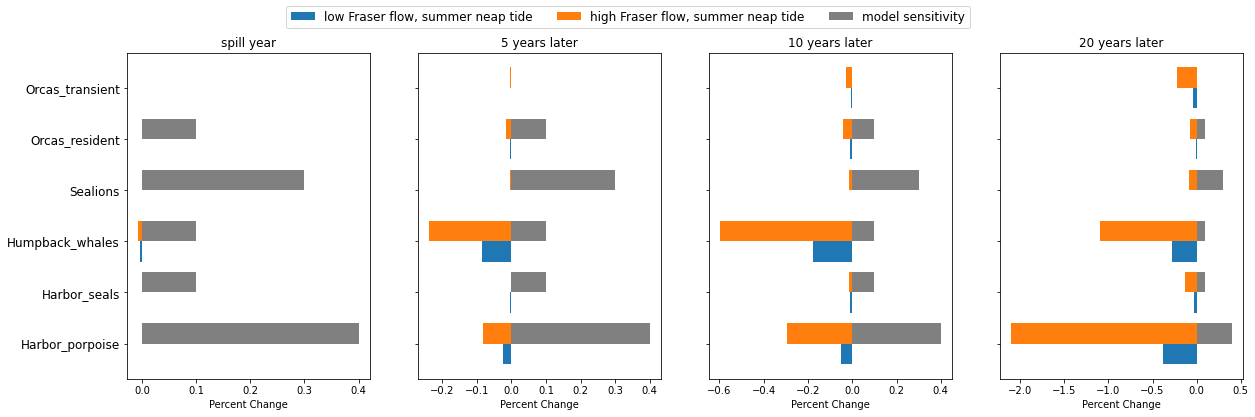

In [21]:
progressive_boxplot_pelagic(groups.mammals)

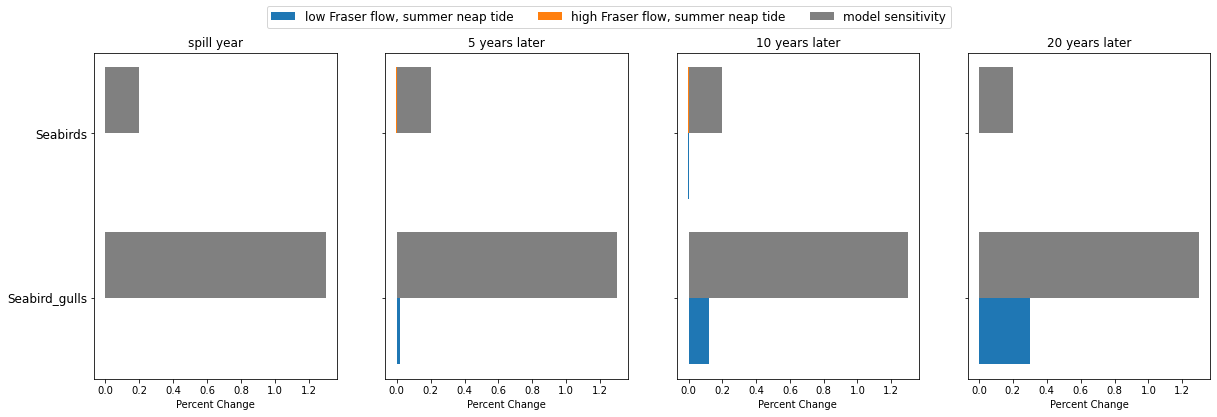

In [22]:
progressive_boxplot_pelagic(groups.birds)

### Plankton

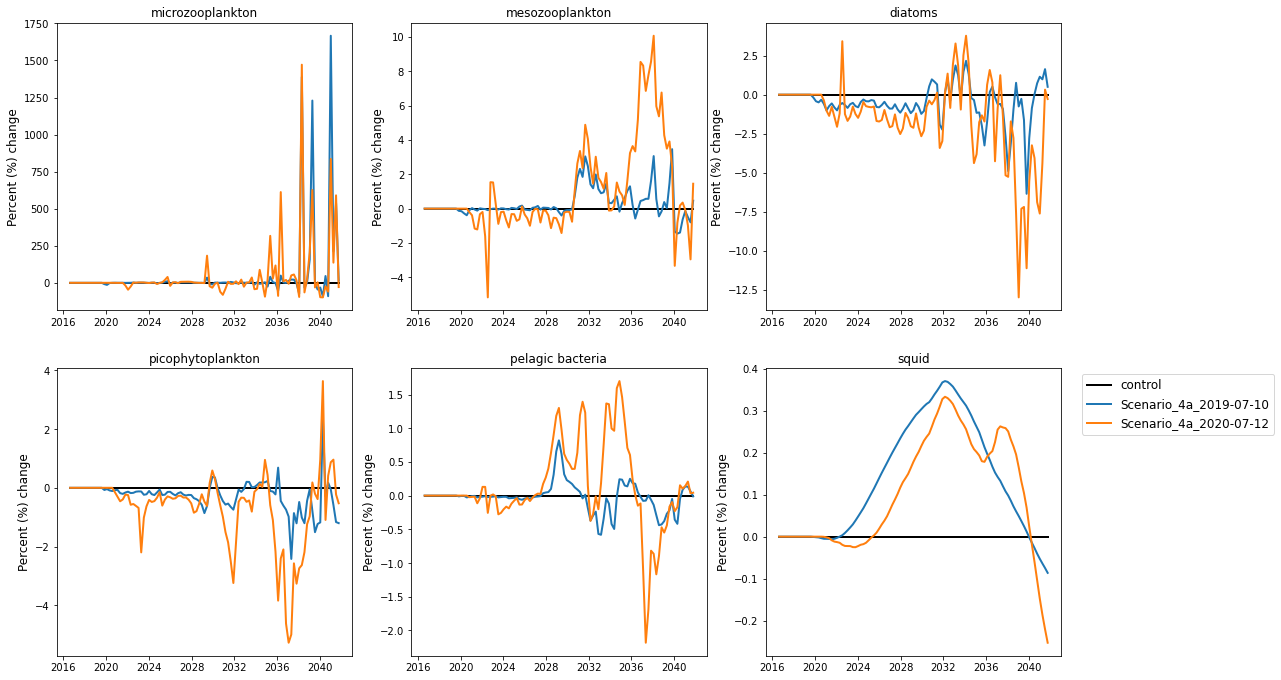

In [23]:
splot.compare_scenarios_pelagic_N(groups.planktonic, scenario_datasets, scenario_paths, control, groups.salish_sea, start, end)

### Vertebrates

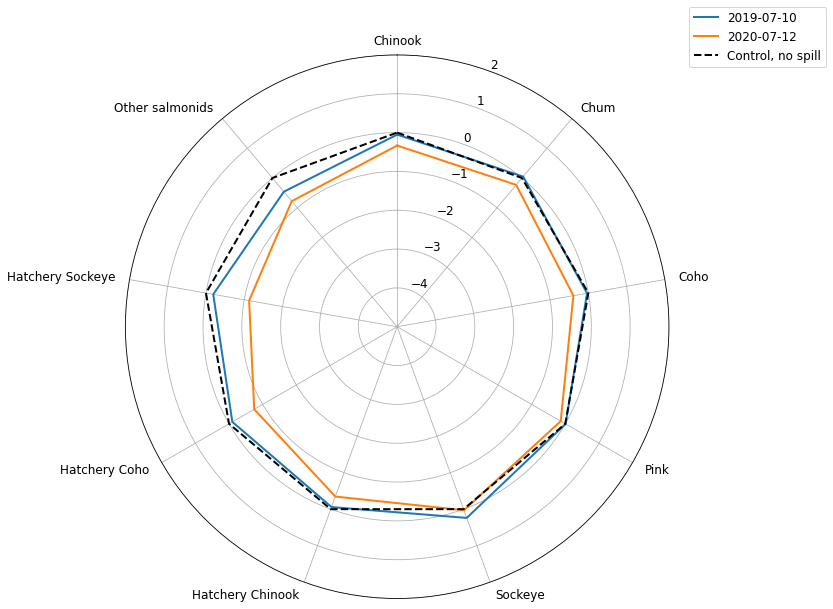

In [25]:
splot.plot_radar_vertebrates(groups.salmon, scenario_datasets, scenario_paths, control, start, end, groups.salish_sea, max=2)

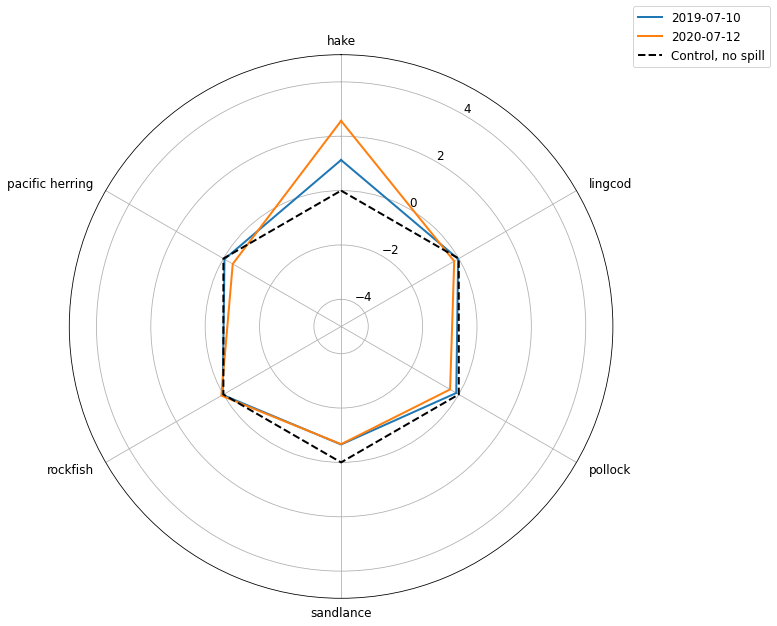

In [ ]:
splot.plot_radar_vertebrates(groups.named_fish, scenario_datasets, scenario_paths, control, start, end, groups.salish_sea, max=5)

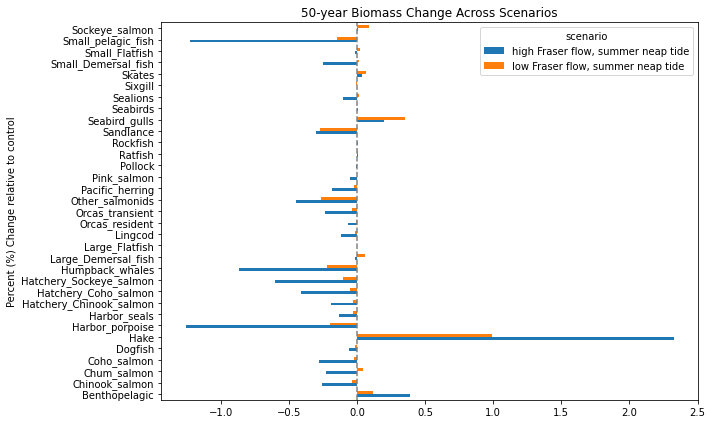

In [ ]:
splot.boxplot_pelagic_vertebrates(groups.all_pelagic_verts, scenario_datasets,scenario_paths,control,location=groups.salish_sea)

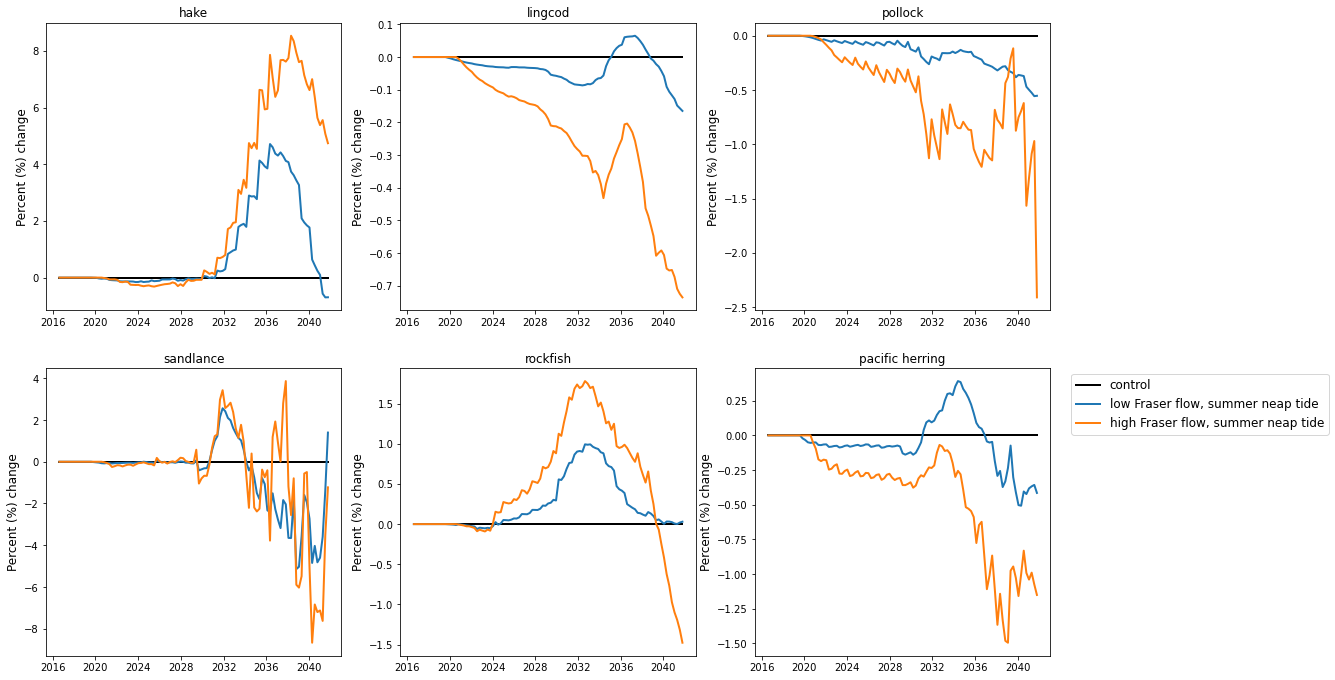

In [28]:
splot.compare_scenarios_vertebrates(groups.named_fish, scenario_datasets, scenario_paths, control, start, end, groups.salish_sea)